In [13]:
import pandas as pd
import numpy as np
import re
import pickle
import string

from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD, NMF
from sklearn.metrics.pairwise import cosine_similarity, euclidean_distances
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from twitter_recommender_api import get_politician_vectors, get_wordnet_pos, text_clean, create_sentiment_vectors, create_similarity_matrix, get_similarities,scrape_tweets, compile_politician_df, recommendation 
import GetOldTweets3 as got

import nltk
from nltk.stem import WordNetLemmatizer 
from nltk.corpus import stopwords
from nltk.corpus import wordnet

import matplotlib.pyplot as plt
plt.style.use('ggplot')
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D

In [21]:
# Loading in prepared pickle files

#loads in already created vectors for all politicians in the bay area
with open("main_politicians_vectorized.pkl", "rb") as f:
    main_politicians_vectorized = pickle.load(f)

#loads in already created vectors for test politicians Joe Biden, Donald Trump and Alexandria Ocasio-Cortez
with open("all_counties_vectorized.pkl", "rb") as f:
    all_counties_vectorized = pickle.load(f)

# Loading in the data

In [3]:
#loading all the candidates running for office in March, 2020 in California
all_elections_ca = pd.read_excel('data/csv-voter-nominated-candidates.xls')
all_elections_ca

,ELECTION_DATE,ELECTION_NAME,COUNTY_ID,COUNTY_NAME,CONTEST_ID,CONTEST_NAME,CANDIDATE_ID,CANDIDATE_NAME,INCUMBENT_FLAG,WRITE_IN_FLAG,PARTY_ID,PARTY_NAME,VOTE_TOTAL
0,03/03/2020,2020 Statewide Direct Primary,1,Alameda,110000130000,United States Representative District 13,581,Barbara Lee,Y,N,1,Democratic,230482
1,03/03/2020,2020 Statewide Direct Primary,1,Alameda,110000130000,United States Representative District 13,885,Nikka Piterman,N,N,3,Republican,18553
2,03/03/2020,2020 Statewide Direct Primary,1,Alameda,110000150000,United States Representative District 15,523,Peter Yuan Liu,N,N,3,Republican,12393
3,03/03/2020,2020 Statewide Direct Primary,1,Alameda,110000150000,United States Representative District 15,552,Alison Hayden,N,N,3,Republican,25395
4,03/03/2020,2020 Statewide Direct Primary,1,Alameda,110000150000,United States Representative District 15,565,Austin E. Intal,N,N,1,Democratic,2431
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1766,03/03/2020,2020 Statewide Direct Primary,59,State Totals,130000790000,State Assembly Member District 79,811,John Moore,N,N,3,Republican,19619
1767,03/03/2020,2020 Statewide Direct Primary,59,State Totals,130000790000,State Assembly Member District 79,812,Shirley N. Weber,Y,N,1,Democratic,74121
1768,03/03/2020,2020 Statewide Direct Primary,59,State Totals,130000800000,State Assembly Member District 80,813,Lorena Gonzalez,Y,N,1,Democratic,56872
1769,03/03/2020,2020 Statewide Direct Primary,59,State Totals,130000800000,State Assembly Member District 80,814,Lincoln Pickard,N,N,3,Republican,7334


In [4]:
#just grabbing the bay area races
alameda = all_elections_ca.COUNTY_NAME == 'Alameda'
cc = all_elections_ca.COUNTY_NAME == 'Contra Costa'
marin = all_elections_ca.COUNTY_NAME == 'Marin'
napa = all_elections_ca.COUNTY_NAME == 'Napa'
sf = all_elections_ca.COUNTY_NAME == 'San Francisco'
sm = all_elections_ca.COUNTY_NAME == 'San Mateo'
sc = all_elections_ca.COUNTY_NAME == 'Santa Clara'
so = all_elections_ca.COUNTY_NAME == 'Solano'
vote = all_elections_ca.VOTE_TOTAL > 4500

sf_bay_area_politicians = all_elections_ca[(alameda | cc | marin | napa | sf | sm | sc | so) & vote]

In [5]:
#dropping duplicates
sf_bay_area_politicians = sf_bay_area_politicians.drop_duplicates(subset='CANDIDATE_ID')

In [6]:
sf_bay_area_politicians.head(3)

,ELECTION_DATE,ELECTION_NAME,COUNTY_ID,COUNTY_NAME,CONTEST_ID,CONTEST_NAME,CANDIDATE_ID,CANDIDATE_NAME,INCUMBENT_FLAG,WRITE_IN_FLAG,PARTY_ID,PARTY_NAME,VOTE_TOTAL
0,03/03/2020,2020 Statewide Direct Primary,1,Alameda,110000130000,United States Representative District 13,581,Barbara Lee,Y,N,1,Democratic,230482
1,03/03/2020,2020 Statewide Direct Primary,1,Alameda,110000130000,United States Representative District 13,885,Nikka Piterman,N,N,3,Republican,18553
2,03/03/2020,2020 Statewide Direct Primary,1,Alameda,110000150000,United States Representative District 15,523,Peter Yuan Liu,N,N,3,Republican,12393


In [7]:
#adding twitter handles to the dataframe
sf_bay_area_politicians['twitter_handle'] = ['RepBarbaraLee','NikkaGOP', 'PeterLiuCAGov18', 'Alison4Congress', 'SamBethechange', None, 'RepSwalwell',
 'RoKhanna', 'tandon4congress', 'Steve_Glazer', None, 'Marisol4CA', 'NancySkinnerCA', 'SaraB4AD15', None, 'BuffyWicks',
 'BauerKahan', None, 'RobBontaCA', None, None, None, 'AsmBillQuirk', 'EastBayAlexis', 'Bob4Assembly', 'Gupta4Assembly',
 'RepThompson', 'RepMcNerney', None, None, 'RepDeSaulnier', None, None, 'BillDoddCA', 'AsmFrazier',
 'AsmGrayson', None, 'CallMeCassieD', None, 'RepHuffman', 'RachelMoniz', 'AsmMarcLevine', 'VeRoniCaJacobi1',
 'RonAssembly', None, 'AsmAguiarCurry', None, 'SpeakerPelosi', 'ShahidForChange', 'RealJohnDennis', 'TomGallagherSF',
 'DeAnna4Congress', 'RepSpeier', 'Scott_Wiener', 'JackieFielder_', None, 'DavidChiu', 'AsmPhilTing', None, None,
 None, 'erictaylorHQ', 'RepAnnaEshoo', 'rishikumar1', 'JoshBeckerSV', 'votebrownrigg', None,
 None, 'skmasur', 'annieoliva2020', None, 'kevinmullin', None, 'AsmMarcBerman', None, None, None,
 None, None, 'iicruzusa', 'RepZoeLofgren', None, None, 'DaveCortese', None, None, 
 None, 'AnnMRavel', 'mariacadenas', None, 'vicki4senate', None, 'VoteAlexLee2020', None,
 'Anthonyjphan', None, 'Ash_Kalra', None, None, 'Evan_Low', None, None, 'AsmMarkStone',
 'AsmRobertRivas', None, 'RepGaramendi', 'seanfeucht', 'TamikaGHamilton']



In [8]:
#combining the two dataframes together
all_elections_ca = all_elections_ca.merge(sf_bay_area_politicians[['CANDIDATE_NAME','twitter_handle']],
                       how='outer',on='CANDIDATE_NAME')


In [9]:
#replacing NA values
all_elections_ca.twitter_handle = all_elections_ca.twitter_handle.fillna('Limited or No Twitter')

In [10]:
#testing grabbing candidates with Twitter profiles in a county
hey = sf_bay_area_politicians[sf_bay_area_politicians.COUNTY_NAME == 'San Francisco']
hey = hey[hey.twitter_handle != 'No Twitter']

In [23]:
def whole_enchilada(county_name, personal_handle, user_input=False, top_words=False, top_words_amount=200):
    """
    Purpose: This is a function that encompasses everything I've worked on for this project and will be used in
    the heroku app as a recommendation engine. 
    Arguments: county name, personal_twitter_handle, user_input boolean if it is accepting user_input, top_words
    if I'm using sentiment analysis on the top words, and how many top words to include in the sentiment analysis
    Returns: A recommendation for every political race in the county based on the personal handle inputted
    """

    #retrieving the dataframe and number of tweets dictionary for the specific county from the pickle file
    for county in all_counties_vectorized:
        if county[0] == county_name:
            df = county[1]
            number_tweets_dict = county[2]
    
    #compile the full dataframe with word vectors for each politician
    full_politician_df,number_tweets_dict = compile_politician_df(df, personal_handle,
    main_politicians_vectorized = main_politicians_vectorized, number_tweets_dict = number_tweets_dict,user_input=user_input,
     top_words=top_words,top_words_amount=top_words_amount)
    
    #getting cosine similarity metrics for each politician and the twitter handle that the user inputted
    sims = get_similarities(personal_handle, full_politician_df, cosine_similarity)
    
    #adding cosine similarity and number of tweets to the table with all politicians in county
    all_politicians_in_county = all_elections_ca[all_elections_ca.COUNTY_NAME == county_name]
    complete_table = all_politicians_in_county.merge(sims[1:], how='outer',left_on='twitter_handle', right_index=True )
    complete_table['number_of_tweets'] = complete_table['twitter_handle'].map(number_tweets_dict)
    
    #cleaning up the data so it looks nicer when shown
    complete_table['number_of_tweets'] = complete_table['number_of_tweets'].fillna('Limited or No Twitter')

    #getting the recommendation for each political contest in the county
    dataframes,candidates_to_vote_for = recommendation(complete_table=complete_table, personal_handle=personal_handle,num_tweets=number_tweets_dict)

    #plotting each politician's twitter profile in 2 dimensions 
    reduced_data = PCA(n_components=2).fit_transform(full_politician_df)
    results = pd.DataFrame(reduced_data,columns=['pca1','pca2'],index=full_politician_df.index)
    
    plt.figure(figsize=(12,8))
    sns.scatterplot(x="pca1", y="pca2", s=200,hue=results.index, data=results)
    plt.title('Political Spectrum')
    plt.show()
    
    return rec,sims

United States Representative District 13
     COUNTY_NAME  CANDIDATE_NAME  PARTY_NAME   AOC number_of_tweets
0  San Francisco  Nikka Piterman  Republican  0.68             1441
1  San Francisco     Barbara Lee  Democratic  0.66             1670


United States Representative District 12
     COUNTY_NAME   CANDIDATE_NAME  PARTY_NAME                    AOC  \
0  San Francisco  Deanna Lorraine  Republican                   0.61   
1  San Francisco     Nancy Pelosi  Democratic                    0.5   
2  San Francisco    Tom Gallagher  Democratic                   0.41   
3  San Francisco      John Dennis  Republican                   0.39   
4  San Francisco    Shahid Buttar  Democratic                   0.29   
5  San Francisco   Agatha Bacelar  Democratic  Limited or No Twitter   

        number_of_tweets  
0                   3445  
1                   1322  
2                    400  
3                   1679  
4                   4476  
5  Limited or No Twitter  


United States Re

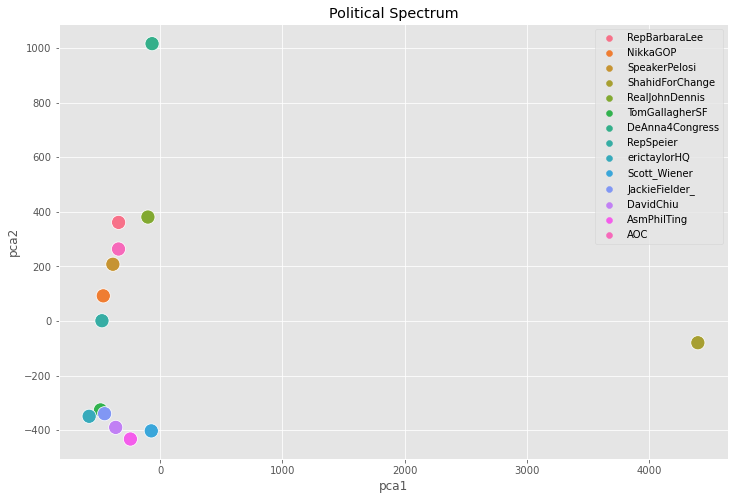

NameError: name 'rec' is not defined

In [24]:
recommendations,overall_ranking = whole_enchilada('San Francisco','AOC', top_words=True)

At this point after enough trials, I think the best way to layer in sentiment analysis is to take the sentiment for tweets containing the top 200 words and add it to each politician vector.